In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VECM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the train dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Convert the 'Date' column to datetime type
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Display the first few rows of the dataframe
train_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [3]:
# Convert the 'date' column to datetime type
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Set the 'Date' column as the index
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# Ensure there are no missing values in the critical columns
train_df.dropna(subset=['store', 'product', 'number_sold'], inplace=True)
test_df.dropna(subset=['store', 'product', 'number_sold'], inplace=True)

Trend Analysis

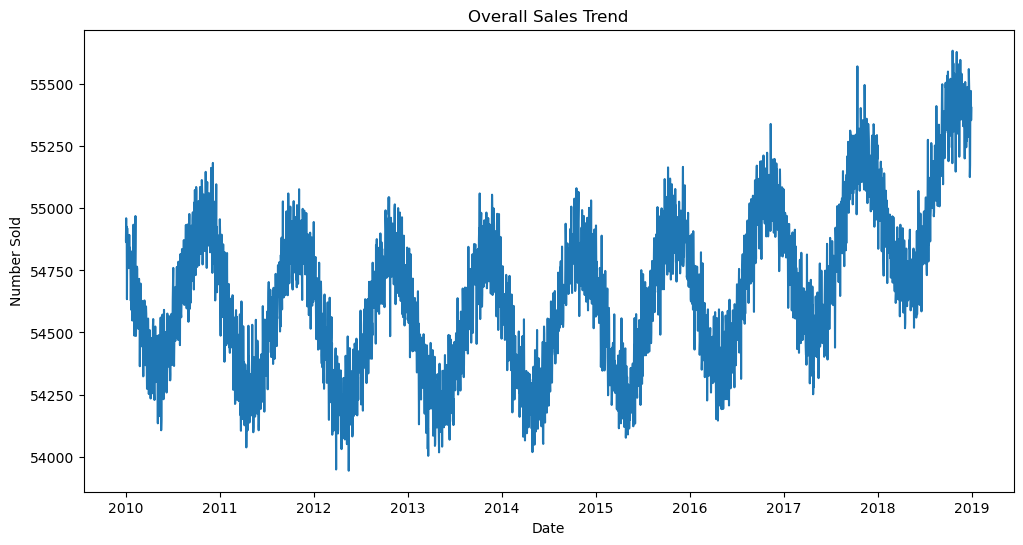

In [4]:
# Group the data by date to see the overall trend
daily_sales = train_df.groupby(train_df.index).sum()

# Plot the overall trend
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['number_sold'])
plt.title('Overall Sales Trend')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.show()


Seasonality Analysis

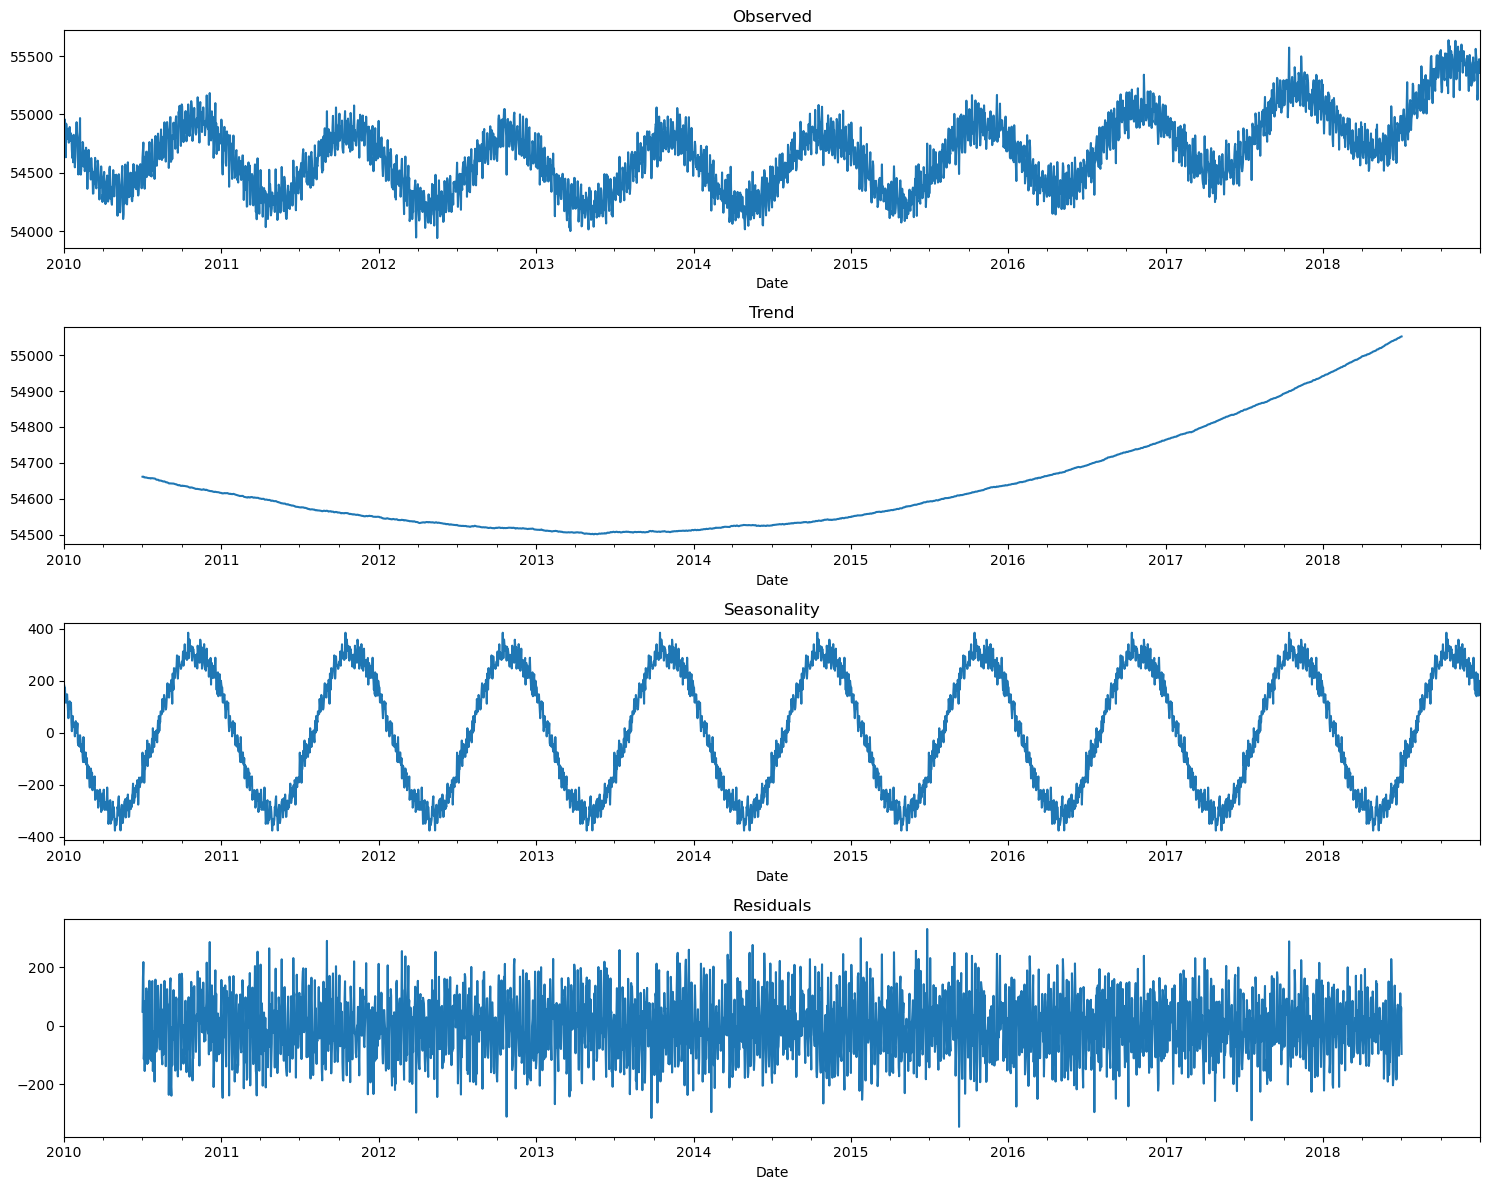

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(daily_sales['number_sold'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonality')
decomposition.resid.plot(ax=ax4, title='Residuals')
plt.tight_layout()
plt.show()

Cyclic Patterns

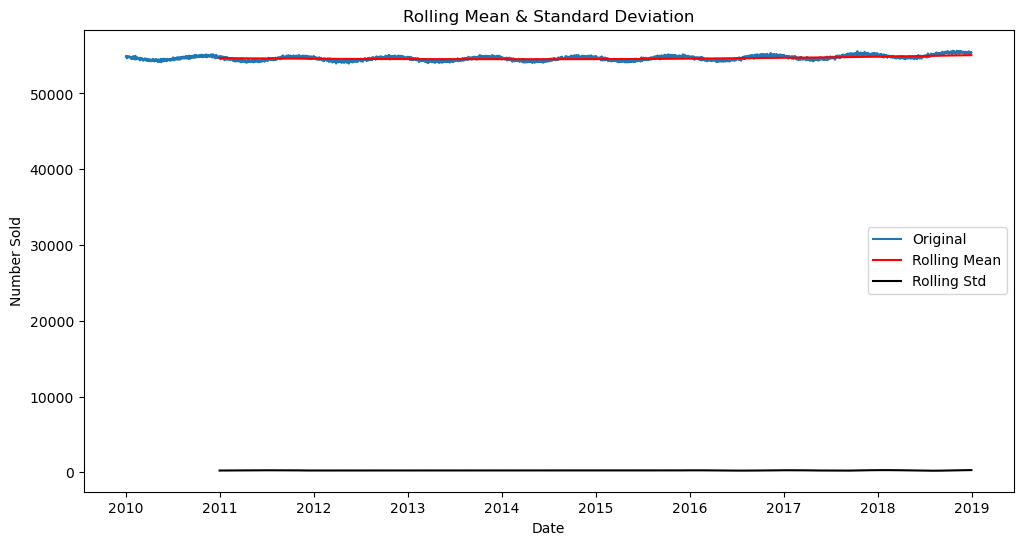

In [6]:
#Cyclic patterns are longer-term fluctuations compared to seasonality. They do not have a fixed period.
# Cyclic patterns can be identified using rolling statistics
rolling_mean = daily_sales['number_sold'].rolling(window=365).mean()
rolling_std = daily_sales['number_sold'].rolling(window=365).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['number_sold'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.show()

Stationarity Analysis

In [7]:
#Stationarity means that the statistical properties of the time series such as mean and variance remain constant over time. 
# Perform the Augmented Dickey-Fuller test
result = adfuller(daily_sales['number_sold'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -2.5323697134562484
p-value: 0.10779573173603091
Critical Value (1%): -3.4323593525669414
Critical Value (5%): -2.8624278120183573
Critical Value (10%): -2.567242601304915


Given the ADF test results, we fail to reject the null hypothesis of non-stationarity. This indicates that the time series is not stationary.

ADF Statistic (Differenced): -7.113038701555923
p-value (Differenced): 3.8942498293860627e-10
Critical Value (1%): -3.432359970177518
Critical Value (5%): -2.862428084811229
Critical Value (10%): -2.5672427465340872


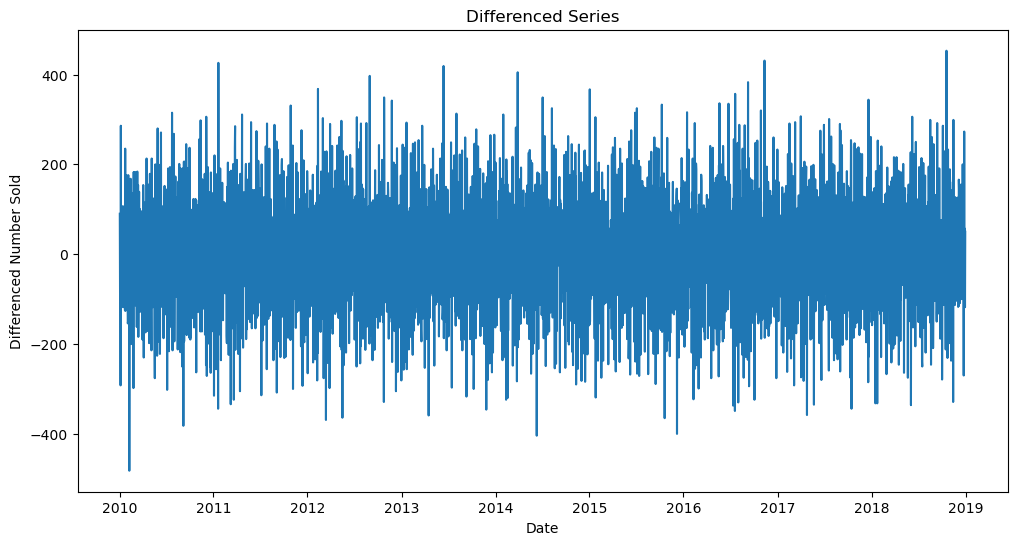

In [8]:
# First-order differencing
daily_sales_diff = daily_sales['number_sold'].diff().dropna()

# Perform the ADF test again on the differenced series
result_diff = adfuller(daily_sales_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_diff)
plt.title('Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Number Sold')
plt.show()

Autocorrelation and Lag Analysis

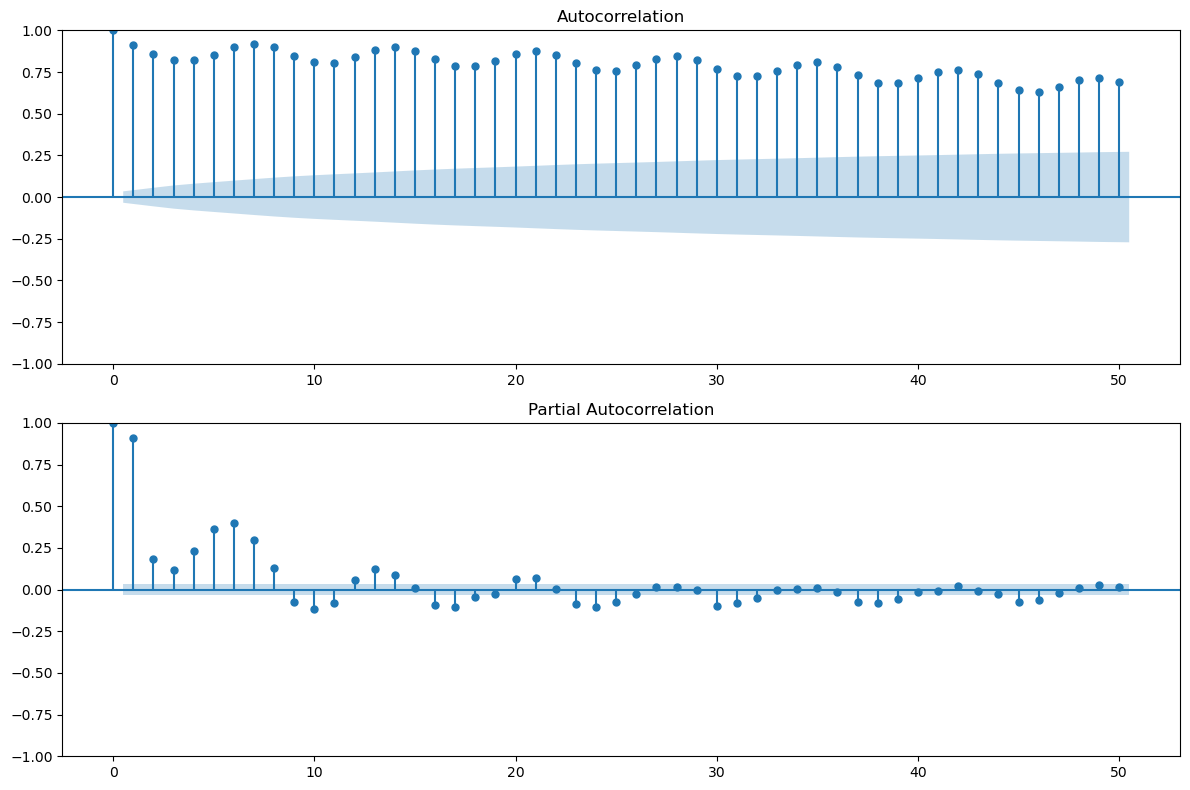

In [9]:
#Autocorrelation is the correlation of the time series with a lagged version of itself. 
#The ACF and PACF plots can be used to analyze this.
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(daily_sales['number_sold'], lags=50, ax=ax[0])
plot_pacf(daily_sales['number_sold'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

Amplitude and Frequency

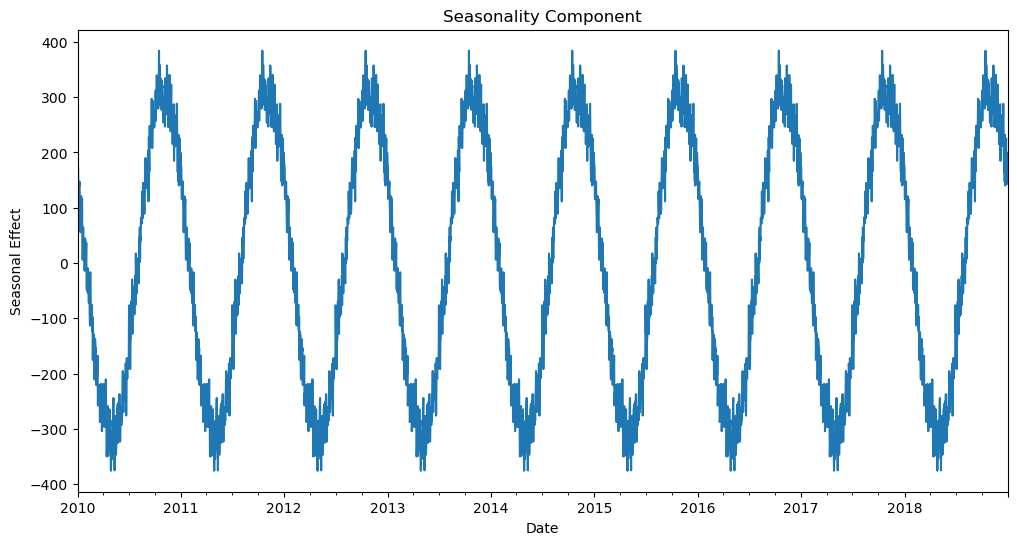

In [10]:
# Amplitude and frequency can be visualized through seasonality plots

# Plot the seasonal component again for amplitude and frequency analysis
plt.figure(figsize=(12, 6))
decomposition.seasonal.plot()
plt.title('Seasonality Component')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()

Volatility

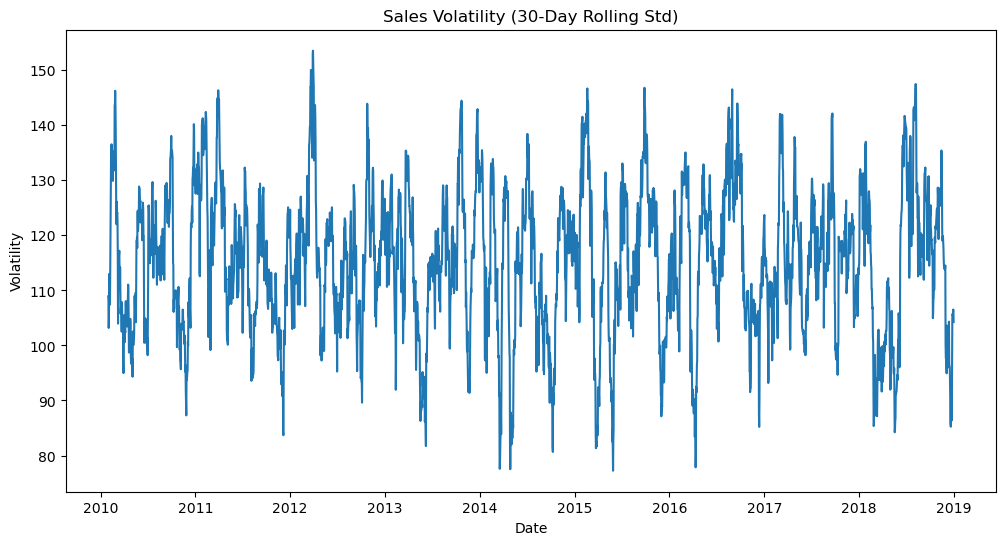

In [11]:
# Volatility can be analyzed by plotting the standard deviation over a rolling window
volatility = daily_sales['number_sold'].rolling(window=30).std()

# Plot the volatility
plt.figure(figsize=(12, 6))
plt.plot(volatility)
plt.title('Sales Volatility (30-Day Rolling Std)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

Forecast

In [12]:
# Aggregate the data by store and product
daily_sales_train = train_df.groupby(['Date', 'store', 'product']).sum().unstack(level=[1, 2]).fillna(0)
daily_sales_test = test_df.groupby(['Date', 'store', 'product']).sum().unstack(level=[1, 2]).fillna(0)

# Convert to a panel format
daily_sales_train.columns = daily_sales_train.columns.droplevel(0)
daily_sales_test.columns = daily_sales_test.columns.droplevel(0)

# Flatten the MultiIndex columns
daily_sales_train.columns = ['{}_{}'.format(store, product) for store, product in daily_sales_train.columns]
daily_sales_test.columns = ['{}_{}'.format(store, product) for store, product in daily_sales_test.columns]

In [ ]:
# Determine the maximum allowable lags based on the size of the training set
# Fit VECM model
model_vecm = VECM(daily_sales_train)
model_vecm_fit = model_vecm.fit()

# Forecast
forecast_vecm = model_vecm_fit.predict(steps=len(daily_sales_test))

# Calculate the error on the test set
test_error_vecm = mean_squared_error(daily_sales_test.values, forecast_vecm)
test_error_vecm_per = mean_absolute_percentage_error(daily_sales_test.values, forecast_vecm)

print(f'Test MSE (VECM): {test_error_vecm}')
print(f'Test MAPE (VECM): {test_error_vecm_per}')

In [ ]:
# Plot the forecast for a sample store-product combination
sample_col = daily_sales_test.columns[0]

plt.figure(figsize=(12, 6))
plt.plot(daily_sales_train.index, daily_sales_train[sample_col], label='Observed (Train)')
plt.plot(daily_sales_test.index, daily_sales_test[sample_col], label='Observed (Test)')
plt.plot(daily_sales_test.index, forecast_vecm[:, 0], label='Forecast (VECM)')
plt.title(f'Sales Forecast for {sample_col} (VECM)')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.show()